---
title: "Social Hygiene: Pruning my Twitter Feed with Plumes"
subtitle: ""
summary: ""
authors: []
tags: [twitter,python,cli]
categories: []
date: 2020-09-08
lastmod: 2020-09-08
featured: false
draft: false

image:
  caption: ""
  focal_point: ""
  preview_only: false
---


While scrolling through my Twitter feed recently, I began to get a little annoyed at the amount of content that I was simply not interested in.
In engineering terms, my signal-to-noise ratio was way too low.

This led me to think about my social media hygene and how I don't tend to prune my tweets, people I follow, or topics of interest.

So, over a few days off, I made a tool: [`plumes`](https://github.com/nnadeau/plumes).

I designed `plumes` to be a simple Twitter CLI for day-to-day social media hygiene, allowing me to perform basic pruning operations.
My end goal was to make a cron job that would perform typical operations at a scheduled interval.

In this post, I'll be walking through my pruning process using `plumes` as I try to achieve a more reasonable level of Twitter content quality.
I have two overall goals:

1. Prune my tweets: delete old and low-value tweets
2. Prune my friends: unfollow people based on certain criteria

## Extracting Twitter Data

First, we need data.

The `plumes` CLI makes this pretty straight forward:

```bash
plumes tweets
plumes friends
```

The above commands give me all my tweets and all my friends (i.e., people I follow) as two JSON files, [`EngNadeau-tweets.json`](EngNadeau-tweets.json) and [`EngNadeau-friends.json`](EngNadeau-friends.json), respectively.

## Analyzing and Pruning Tweets

Let's take a look at my tweets.
Using the JSON output from `plumes`, we can load the data and get an idea of my tweeting habits and quality.

### Loading Data

Loading the data is a simple JSON -> DataFrame process:

In [1]:
import json
from pathlib import Path
import pandas as pd

# nicer pandas float formatting
pd.options.display.float_format = "{:g}".format

# load data
path = Path("EngNadeau-tweets.json")
with open(path) as f:
    data = json.load(f)

# convert to pandas dataframe
df = pd.json_normalize(data).pipe(
    lambda x: x.assign(**{"created_at": pd.to_datetime(x["created_at"])})
)

df

,created_at,id,id_str,text,truncated,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,retweeted_status.quoted_status.place.contained_within,retweeted_status.quoted_status.place.bounding_box.type,retweeted_status.quoted_status.place.bounding_box.coordinates,retweeted_status.quoted_status.entities.media,retweeted_status.quoted_status.extended_entities.media,retweeted_status.scopes.followers,retweeted_status.geo.type,retweeted_status.geo.coordinates,retweeted_status.coordinates.type,retweeted_status.coordinates.coordinates
0,2020-08-20 17:50:52+00:00,1296504993260896258,1296504993260896258,Shoutout to @thedungeoncast for their breaks’ ...,False,"<a href=""http://twitter.com/download/iphone"" r...",nan,None,nan,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-08-18 14:59:41+00:00,1295737134972903425,1295737134972903425,My personal shoutout = eReader + @LibbyApp + @...,False,"<a href=""http://twitter.com/download/iphone"" r...",nan,None,nan,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-08-18 03:00:46+00:00,1295556215351717888,1295556215351717888,Accidentally published their private keys http...,False,"<a href=""http://twitter.com/download/iphone"" r...",nan,None,nan,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-08-17 19:52:11+00:00,1295448359004786694,1295448359004786694,This may be one of my favourite #bot features:...,False,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.29545e+18,1295448001100623875,8.10231e+07,81023088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-08-17 19:50:46+00:00,1295448001100623875,1295448001100623875,Pybotics -&gt; https://t.co/4YRC6gqOxf\nsemant...,False,"<a href=""https://mobile.twitter.com"" rel=""nofo...",1.29545e+18,1295447755469594624,8.10231e+07,81023088,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,2014-08-19 20:16:49+00:00,501825129739845632,501825129739845632,RT @Brainsight: Organized a few useful Brainsi...,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",nan,None,nan,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1679,2014-08-16 22:39:25+00:00,500773855523504128,500773855523504128,"Researchers create 1,000-robot swarm\nhttp://t...",False,"<a href=""http://twitter.com/#!/download/ipad"" ...",nan,None,nan,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1680,2014-08-07 04:03:12+00:00,497231458550177793,497231458550177793,Officially got my Quebec junior engineering pe...,False,"<a href=""http://twitter.com/#!/download/ipad"" ...",nan,None,nan,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1681,2014-08-07 02:33:08+00:00,497208793118552064,497208793118552064,@Brainsight @JLMorris91 #brainsight #TMS http:...,False,"<a href=""http://twitter.com/#!/download/ipad"" ...",3.26715e+17,326715209219702785,5.04317e+08,504317349,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exploring Data

Wow, I never thought of myself as a "tweeter", but 1600+ tweets is pretty cool.

Moreover, the data is very nicely structured, and the [`pandas.normalize_json()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.json_normalize.html) is wonderful at converting the semi-structured JSON data into a flat table.

Let's take a closer look as some statistics:

In [2]:
df[["retweet_count", "favorite_count"]].describe()

,retweet_count,favorite_count
count,1683,1683
mean,177.448,0.75817
std,5146.03,1.75906
min,0,0
25%,0,0
50%,0,0
75%,1,1
max,209899,21


Hmmmm, I don't remember ever going viral and getting 200k+ retweets. 

Per the [Twitter API docs](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object), the `retweet_count` key of a Tweet object counts the source tweet's retweets, not just my personal retweets.

Let's filter out retweets to get just my personal tweets.
Since we're beginning to chain conditions, filters, transforms, etc. on our dataframe, I'll begin using [`pipes`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html) to keep the code clean and efficient.
(Note: I LOVE pipes).

In [3]:
(
    df.pipe(lambda x: x[~x["retweeted"]])
    .pipe(lambda x: x[["retweet_count", "favorite_count"]])
    .describe(percentiles=[0.5, 0.9, 0.95, 0.99])
)

,retweet_count,favorite_count
count,1376,1376
mean,0.205669,0.919331
std,0.732019,1.89699
min,0,0
50%,0,0
90%,1,2
95%,1,4
99%,4,9
max,11,21


Aha! That's more like it.

So I have around 1.3k personal tweets and I definitely never went viral.

### Tweets vs. Time

I wonder what this looks like over time?

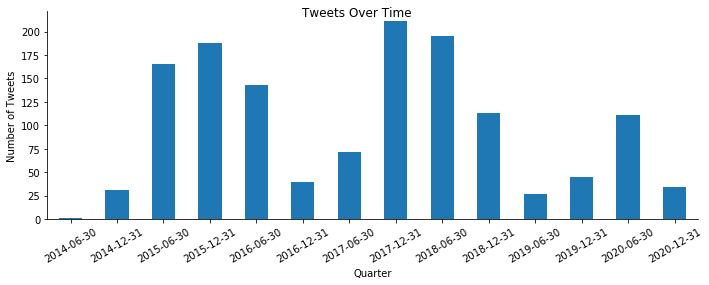

In [4]:
from matplotlib import pyplot as plt
import matplotlib as mpl

mpl.rcParams["axes.spines.right"] = False
mpl.rcParams["axes.spines.top"] = False

figsize=(10, 4)

fig, ax = plt.subplots(figsize=figsize)

(
    df.pipe(lambda x: x[~x["retweeted"]])
    .set_index("created_at")
    .resample("2Q")
    .count()
    .pipe(lambda x: x.set_index(x.index.date))
    .pipe(lambda x: x["id"])
    .plot.bar(ax=ax, rot=30)
)

fig.suptitle("Tweets Over Time")
ax.set_xlabel("Quarter")
ax.set_ylabel("Number of Tweets")
fig.tight_layout()

It appears that I tend to be cyclical with my tweets.
Here are some highlights I can think of:

- 2015-2016: Attended medical conferences and was tweeting to promote my company.
- 2017-2018: Attended robotics conferences and was tweeting to promote my research.
- 2019: Writing my PhD thesis and forgot about the rest of the world.

### Interactions vs. Time

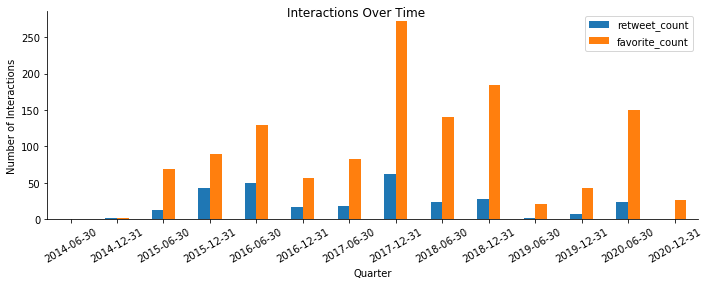

In [5]:
fig, ax = plt.subplots(figsize=figsize)

(
    df.pipe(lambda x: x[~x["retweeted"]])
    .set_index("created_at")
    .resample("2Q")
    .sum()
    .pipe(lambda x: x.set_index(x.index.date))
    .pipe(lambda x: x[["retweet_count", "favorite_count"]])
    .plot.bar(ax=ax, rot=30)
)

fig.suptitle("Interactions Over Time")
ax.set_xlabel("Quarter")
ax.set_ylabel("Number of Interactions")
ax.legend()
fig.tight_layout()

As expected, the number of interactions generally follows my tweeting frequency.
The more you give, the more you get.

But, I did have a stellar quarter in 2017.

### Pruning Tweets

With goal #1 in mind, let's use `plumes` to prune (i.e., delete) old tweets that aren't worth keeping around.
Judging from the previous data and plots (e.g., 99% percentile above), I'd be OK with deleting tweets that:

- Are older than 60 days
- Have less than 9 likes
- Have less than 4 retweets
- Are not self-liked by me

The command (and future cron job) will look like this:

```bash
# add --prune to switch from dry-run to deleting
plumes audit_tweets EngNadeau-tweets.json --min_likes 9 --min_likes 4 --days 60 --self_favorited False
```

This results in 1325 identified tweets that will be deleted.
Goodbye :)

## Analyzing and Pruning Friends

Next, let's take a look at my friends (i.e., people I follow).
Similar to the tweet analysis and pruning process, we'll be using the `plumes` JSON output to get an idea of my following quality.

### Loading Data

Like before, we will simply load the JSON data and convert to a DataFrame.

In [6]:
# load data
path = Path("EngNadeau-friends.json")
with open(path) as f:
    data = json.load(f)

# convert data to pandas dataframe
df = pd.json_normalize(data).pipe(
    lambda x: x.assign(**{"created_at": pd.to_datetime(x["created_at"])})
)

df

,id,id_str,name,screen_name,location,description,url,protected,followers_count,friends_count,...,status.retweeted_status.place.id,status.retweeted_status.place.url,status.retweeted_status.place.place_type,status.retweeted_status.place.name,status.retweeted_status.place.full_name,status.retweeted_status.place.country_code,status.retweeted_status.place.country,status.retweeted_status.place.contained_within,status.retweeted_status.place.bounding_box.type,status.retweeted_status.place.bounding_box.coordinates
0,86315276,86315276,Will Strafach,chronic,"San Francisco, CA",building great things. breaking others. | foun...,https://t.co/7qRzHeZcxy,False,60239,5265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,15752235,15752235,Zack Whittaker,zackwhittaker,"New York, NY",Security editor @TechCrunch • Signal / WhatsAp...,https://t.co/0I0oRqFMAy,False,59392,998,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,776454093816594433,776454093816594433,Oliver Limoyo,OliverLimoyo,,PhD. candidate @UofTRobotics @VectorInst study...,https://t.co/I8kDSFF4Jp,False,71,306,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1079370278424272898,1079370278424272898,AppsCyborg,AppsCyborg,World,Home of all cyborg web apps. All our apps are ...,https://t.co/djpFssnWsi,False,825,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,19510090,19510090,Julian Togelius,togelius,New York City,AI and games researcher.\nAssociate professor ...,http://t.co/j74XjVzSps,False,10675,983,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,14269152,14269152,Anthony Ha,anthonyha,"New York, NY","Journalism for @TechCrunch, science fiction fo...",https://t.co/2dWc2EzwK6,False,43278,731,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1409,2384071,2384071,timoreilly,timoreilly,"Oakland, CA","Founder and CEO, O'Reilly Media. Watching the ...",https://t.co/HsFlR6PWvT,False,1766687,2121,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410,22938914,22938914,Steve Wozniak,stevewoz,"Los Gatos, California",Engineers first! Human rights. Gadgets. Jokes ...,http://t.co/gC1NnB1hgl,False,626501,92,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1411,1835411,1835411,Andy Ihnatko,Ihnatko,Sector ZZ9 Plural Z Alpha,"Tech contributor to @bospublicradio @WGBH, pod...",http://t.co/xoCNd62Xhn,False,88918,1916,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Like the tweets data before, the users JSON data is also nicely structured.

According to this (and my Twitter profile), I follow 1.4k+ people.
I definitely don't interact with that many people, nor pay attention to them.
Let's explore the data a little more and then clean this up.

### Exploring Data

First, let's take a look at basic user statistics:

In [7]:
df.filter(like="_count").describe()

,followers_count,friends_count,listed_count,favourites_count,statuses_count,status.retweeted_status.retweet_count,status.retweeted_status.favorite_count,status.retweet_count,status.favorite_count
count,1413,1413,1413,1413,1413,348,348,1413,1413
mean,1.26141e+06,1898.8,6021.76,11701.3,28546.4,1421.52,6146.5,429.389,490.885
std,5.78562e+06,16325.6,16785.9,41353.2,62321.8,7092.65,31651.4,3723.26,5379.2
min,71,0,0,0,6,1,0,0,0
25%,9213,240,233,704,2970,4,11.75,0,0
50%,48128,630,910,3045,8630,15,49.5,3,2
75%,343911,1412,4251,9261,23789,95.25,434.5,15,18
max,1.21754e+08,602053,221282,1.03488e+06,654080,63247,367412,63247,164625


Above we have a lot of useful info.
From a segmentation perspective, `followers_count` followed by `statuses_count` gives the biggest variance if we wanted to classify our users into groups.

However, who are the super popular people that are outliers compared to the rest of my friends?

In [8]:
df.sort_values(by="followers_count", ascending=False).head()

,id,id_str,name,screen_name,location,description,url,protected,followers_count,friends_count,...,status.retweeted_status.place.id,status.retweeted_status.place.url,status.retweeted_status.place.place_type,status.retweeted_status.place.name,status.retweeted_status.place.full_name,status.retweeted_status.place.country_code,status.retweeted_status.place.country,status.retweeted_status.place.contained_within,status.retweeted_status.place.bounding_box.type,status.retweeted_status.place.bounding_box.coordinates
1407,813286,813286,Barack Obama,BarackObama,"Washington, DC","Dad, husband, President, citizen.",https://t.co/93Y27HEnnX,False,121753699,602053,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000,10228272,10228272,YouTube,YouTube,"San Bruno, CA",Black Lives Matter.,https://t.co/qkVaJFk2CG,False,72161138,1124,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1403,428333,428333,CNN Breaking News,cnnbrk,Everywhere,Breaking news from CNN Digital. Now 58M strong...,http://t.co/HjKR4r61U5,False,58499326,119,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1406,50393960,50393960,Bill Gates,BillGates,"Seattle, WA",Sharing things I'm learning through my foundat...,https://t.co/emd1hfqSRD,False,51520675,228,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1323,759251,759251,CNN,CNN,,It’s our job to #GoThere & tell the most diffi...,http://t.co/IaghNW8Xm2,False,49599588,1108,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Oh... hello Obama.

But this also brings up another issue: who should I actually follow?

As much as I like Obama and Bill Gates, I don't actually interact with them. 
This is especially true for CNN and YouTube. 

If there is something truly worthwhile being tweeted by these people (or orgs), I'll probably hear about it from my thousand other social media sources.
What I want from Twitter is more personal content from people that provide intelligent ideas and good discussion topics. 

Let's start by exploring a user's followers vs. friends and their Twitter Follower-to-Friend (TFF ratio).

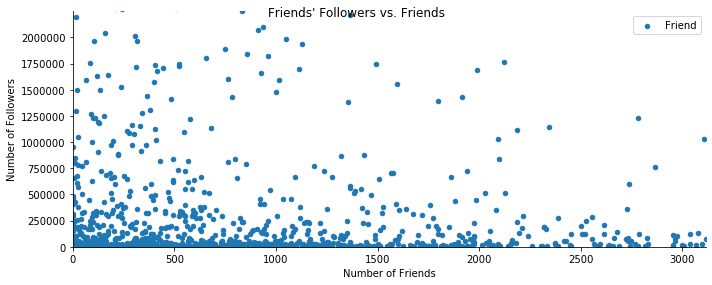

In [9]:
fig, ax = plt.subplots(figsize=figsize)

df.plot.scatter(x="friends_count", y="followers_count", ax=ax, label="Friend")

fig.suptitle("Friends' Followers vs. Friends")
ax.set_xlabel("Number of Friends")
ax.set_ylabel("Number of Followers")
ax.set_xlim([0, df["friends_count"].quantile(q=0.9)])
ax.set_ylim([0, df["followers_count"].quantile(q=0.9)])
ax.legend()
fig.tight_layout()

Right away, we can see that the majority of outliers fall below a TFF ratio of 1.
Below TFF=1, people have many more followers than friends (e.g., celebrities, popular people).
Above TFF=1, you follow a lot of people, but people don't follow you back (e.g., up-and-comers, bots).

So who should I follow?
Let's look at who I've interacted with in the past.

First, I'll load the my past retweets and favourited tweets ([`EngNadeau-favorites.json`](EngNadeau-favorites.json)) data.
Second, I'll extract the users I've retweeted in the past.
Third, I'll compare these users vs. my current friends.

In [10]:
import numpy as np

# load retweet data
path = Path("EngNadeau-tweets.json")
with open(path) as f:
    data = json.load(f)

df_retweeted = (
    pd.json_normalize(data)
    .pipe(lambda x: x.assign(**{"created_at": pd.to_datetime(x["created_at"])}))
    .pipe(lambda x: x[x["retweeted"]])
    .filter(like="retweeted_status")
    .filter(like="_count")
    .pipe(
        lambda x: x.assign(
            ratio=x["retweeted_status.user.followers_count"]
            / x["retweeted_status.user.friends_count"]
        )
    )
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=["ratio"])
)

df_retweeted.describe()

,retweeted_status.user.followers_count,retweeted_status.user.friends_count,retweeted_status.user.listed_count,retweeted_status.user.favourites_count,retweeted_status.user.statuses_count,retweeted_status.retweet_count,retweeted_status.favorite_count,retweeted_status.quoted_status.user.followers_count,retweeted_status.quoted_status.user.friends_count,retweeted_status.quoted_status.user.listed_count,retweeted_status.quoted_status.user.favourites_count,retweeted_status.quoted_status.user.statuses_count,retweeted_status.quoted_status.retweet_count,retweeted_status.quoted_status.favorite_count,ratio
count,302,302,302,302,302,302,302,12,12,12,12,12,12,12,302
mean,681172,6140.14,3436.95,6985.08,27714.4,960.606,1533.55,878613,1547.92,7723.75,5401.75,17302,1878.67,9460.33,6533.61
std,3.61614e+06,68696.8,11923.9,34915.9,89221,12127.6,20802,2.99208e+06,1274.39,25607.8,4931.2,33218.1,6146.83,32156,42805.3
min,15,1,0,0,87,1,0,639,368,33,66,1021,0,2,0.0815217
25%,993,237.25,36,494.25,1753,1,3,2113,675,95,1666.5,2686.25,1.75,7.5,0.872062
50%,3265,712,98,1583.5,5369,3,6,5747.5,1026.5,140.5,4545,5060,6,17.5,5.70978
75%,31005.2,2142,585.25,4501.25,10565.8,26,29,14300.2,2179.25,581.5,7356.25,12165.2,122.25,205.75,39.3201
max,3.81207e+07,1.16459e+06,112742,576330,959614,209899,360915,1.03793e+07,4320,89027,16239,119010,21386,111562,392997


In [11]:
# load favourited tweets data
# run `plumes favorites`
path = Path("EngNadeau-favorites.json")
with open(path) as f:
    data = json.load(f)

df_favorites = (
    pd.json_normalize(data)
    .pipe(lambda x: x.assign(**{"created_at": pd.to_datetime(x["created_at"])}))
    .drop_duplicates(subset="user.screen_name")
    .filter(like="user.")
    .filter(like="_count")
    .pipe(lambda x: x.assign(ratio=x["user.followers_count"] / x["user.friends_count"]))
    .replace([np.inf, -np.inf], np.nan)
    .dropna(subset=["ratio"])
)

df_favorites.describe()

,user.followers_count,user.friends_count,user.listed_count,user.favourites_count,user.statuses_count,quoted_status.user.followers_count,quoted_status.user.friends_count,quoted_status.user.listed_count,quoted_status.user.favourites_count,quoted_status.user.statuses_count,ratio
count,157,157,157,157,157,13,13,13,13,13,157
mean,1.03861e+06,8965.46,3013.01,15381.7,25452.6,52214,1244.15,843.308,7358.92,6584.38,1437.58
std,9.96025e+06,54112.1,19875.2,54028.6,96299.1,115818,1362.51,1763.6,13425.1,8800.26,15243.8
min,15,7,0,0,27,307,0,7,0,78,0.05
25%,887,337,27,608,1352,1146,91,49,233,727,1.38529
50%,5110,830,129,2734,4793,4030,797,157,946,4139,3.74692
75%,31579,1968,547,9695,13670,10556,1409,318,6045,6688,27.2923
max,1.22369e+08,601499,220417,576678,963929,335806,3699,5953,46148,31104,190697


So, from the above, I typically interact with pretty popular people (`retweeted_status.user.followers_count` and `user.followers_count`), but most people fall within a TFF ratio of about 1 to 30.

What does this look like plotted?

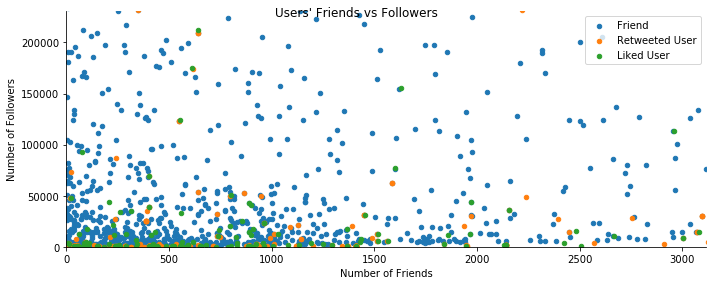

In [12]:
fig, ax = plt.subplots(figsize=figsize)

df.plot.scatter(x="friends_count", y="followers_count", ax=ax, label="Friend")

df_retweeted.plot.scatter(
    x="retweeted_status.user.friends_count",
    y="retweeted_status.user.followers_count",
    ax=ax,
    label="Retweeted User",
    c="C1",
)

df_favorites.plot.scatter(
    x="user.friends_count", y="user.followers_count", ax=ax, label="Liked User", c="C2"
)

fig.suptitle("Users' Friends vs Followers")
ax.set_xlabel("Number of Friends")
ax.set_ylabel("Number of Followers")
ax.set_xlim([0, df["friends_count"].quantile(q=0.9)])
ax.set_ylim([0, df["followers_count"].quantile(q=0.7)])
ax.legend()
fig.tight_layout()

The vast majority of people I interact with are within the core grouping of less than 2k friends and 50k followers (i.e., a TFF ratio of 25).

### Pruning Friends

With goal #2 in mind, we'll use `plumes` to prune friends that I don't typically interact with.
From the previous data and plots, I'll unfriend people that:

- Haven't tweeted in the last 30 days
- Have a TFF ratio less than 1
- Have a TFF ratio more than 30

Since `plumes` assumes the conditional flags are AND boolean operations, we'll need to call the `bool_or` flag to convert the boolean algebra to OR conditions.
The command will look like this:

```bash
# add --prune to switch from dry-run to deleting
poetry run plumes audit_users EngNadeau-friends.json --min_ratio 1 --max_ratio 30 --days 30 --bool_or
```

This results in 912 identified users that will be unfriended.

My Twitter feed has never looked so good. :)